# simulation experiment
The composition schema was developed for integrative simulations, but can also be used for workflows such as simulation experiments.

This is an experimental notebook to demonstrate simulation experiments as composites, going from the declarative JSON format to executable python script.  

Example scripts were provided here: https://docs.google.com/document/d/1jZkaNhM_cOqMWtd4sJZ9b0VGXPTLsDKsRNI5Yvu4nOA/edit

### imports

In [1]:
import inspect
import itertools
from typing import Callable, Any, List, Dict, Union, Optional, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import tellurium as te
import pandas as pd
import json
import textwrap
from bigraph_viz import plot_bigraph, plot_flow, pf

plot_settings = {'remove_process_place_edges': True}
save_images = False
if save_images:
    plot_settings.update({'out_dir': 'out', 'dpi': '250'})

### functions for handling ports, annotations, registration

These are all helper function for handling SED-2. Once stablized, they will be moved to a stand-alone library for handling SED-2 in Python.

In [2]:
# decorators for annotation and ports
def annotate(annotation):
    def decorator(func):
        func.annotation = annotation
        return func
    return decorator


def ports(ports_schema):
    # assert inputs/outputs and types, give suggestions
    allowable = ['inputs', 'outputs']
    assert all(key in  allowable for key in ports_schema.keys()), f'{[key for key in ports_schema.keys() if key not in allowable]} not allowed as top-level port keys. Allowable keys include {str(allowable)}'
    # TODO assert type are in type_registry
    # TODO check that keys match function signature
    def decorator(func):
        func.ports = ports_schema
        return func
    return decorator


# registration
class ProcessRegistry:
    def __init__(self):
        self.registry = {}

    def register(self, func):
        name = func.__name__
        signature = inspect.signature(func)
        annotation = getattr(func, 'annotation', None)
        ports = getattr(func, 'ports')
        
        # TODO -- assert ports and signature match
        if not annotation:
            raise Exception(f'Process {name} requires annotations')
        if not ports:
            raise Exception(f'Process {name} requires annotations')
            
        item = {
            'annotation': annotation,
            'ports': ports,
            'process': func}
        self.registry[name] = item
            
    def access(self, name):
        return self.registry.get(name)
    
    def get_annotations(self):
        return [v.get('annotation') for k, v in self.registry.items()]
    

def register(functions, process_registry=None):
    if not process_registry:
        process_registry = ProcessRegistry()
    for func in functions:
        process_registry.register(func)
    return process_registry


def serialize_instance(wiring):
    def convert_numpy(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        raise TypeError(f'Object of type "{obj.__class__.__name__}" is not JSON serializable')
    
    return json.dumps(wiring, default=convert_numpy)


def deserialize_instance(serialized_wiring):
    if isinstance(serialized_wiring, dict):
        return serialized_wiring
    
    def convert_numpy(obj):
        if isinstance(obj, list):
            return np.array(obj)
        return obj

    return json.loads(serialized_wiring, object_hook=convert_numpy)


def topological_sort(graph):
    """Return list of sorted process names based on dependencies"""
    visited = set()
    sorted_list = []
    def visit(node):
        if node not in visited:
            visited.add(node)
            if node in graph:
                if '_depends_on' in graph[node]:
                    for neighbor in graph[node]['_depends_on']:
                        visit(neighbor)
            sorted_list.append(node)
    for node in graph:
        visit(node)
    return sorted_list


def get_processes_and_states_from_schema(schema, process_registry):
    all_annotations = process_registry.get_annotations()
    
    # separate the processes and states
    processes = {}
    states = {}
    for name, value in schema.items():
        if isinstance(value, dict) and value.get('wires'):
            annotation = value.get('_type')
            if annotation not in all_annotations:
                raise Exception(
                    f'{name} has a type annotation {annotation} not included in the process registry')
            processes[name] = value
        else:
            states[name] = value
    return processes, states


def generate_script(
    schema: Union[str, dict], 
    process_registry: ProcessRegistry
) -> str:
    """Generate an executable Python script from the declarative JSON format"""
    
    schema = deserialize_instance(schema)
    script = []
    
    # separate the processes and states
    processes, states = get_processes_and_states_from_schema(schema, process_registry)
    sorted_processes = topological_sort(processes)
    
    # add states to the top of the script
    for name, value in states.items():
        script.insert(0, f'{name} = {value}')
    
    # add processes to the bottom of the script in their sorted order
    for name in sorted_processes:
        value = processes[name]
        process_entry = process_registry.access(name)
        if process_entry:
            ports = process_entry['ports']
            wires = value['wires']
            func_script = None
            inputs = ports.get('inputs')
            outputs = ports.get('outputs')
            if inputs:
                input_values = [(key, wires[key]) for key in inputs.keys()]
                input_args = ', '.join(f'{arg}={val}' for (arg, val) in input_values)
                func_script = f'{name}({input_args})'
            else:
                func_script = f'{name}()'
            if outputs:
                output_values = [(key, wires[key]) for key in outputs.keys()]
                output_args = ', '.join(f'{val}' for (arg, val) in output_values)
                func_script = f'{output_args} = ' + func_script
            script.append(func_script)
        else:
            raise Exception(f'Function {name} not found in the process registry.') 
    return '\n'.join(script)

### SED-2 processes

These are the processes that are required for the SED-2 examples

In [3]:
class Model:
    def __init__(
        self, 
        sedml_language: str, 
        sbml_file: str
    ):
        self.sedml_language = sedml_language
        self.sbml_file = sbml_file
        self.sbml_model = te.loadSBMLModel(self.sbml_file)

    def set(
        self, 
        element_id: str, 
        value: float
    ):
        if element_id in self.sbml_model.getFloatingSpeciesIds():
            self.sbml_model.setValue(element_id, value)
        elif element_id in self.sbml_model.getGlobalParameterIds():
            self.sbml_model.setValue(element_id, value)
        else:
            raise Exception(f'species {element_id} does not exist') 

    def reset(self):
        self.sbml_model.reset()
    
    def get_value(self, element_id: str) -> float:
        return self.sbml_model.getValue(element_id)


@ports({'inputs': {
            'path_to_sbml': 'str'}, 
        'outputs': {
            'model': 'Model'}})
@annotate('sed:sbml_model_from_path')
def sbml_model_from_path(path_to_sbml):
    return Model('urn:sedml:language:sbml', path_to_sbml)
    

@ports({'inputs': {'model_instance': 'Model'}})
@annotate('sed:model_reset')
def model_reset(model_instance):
    model_instance.reset()

    
@ports({
    'inputs': {
        'model_instance': 'Model',
        'element_id': 'str',
        'value': 'float'}})
@annotate('sed:set_model')
def set_model(model_instance: Model, element_id, value):
    model_instance.set(element_id, value)


@ports({
    'inputs': {
        'model': 'Model',
        'time_start': 'float', 
        'time_end': 'float', 
        'num_points': 'int', 
        'selection_list': 'List[str]'},
    'outputs': {
        'results': 'dict'}})
@annotate('sed:uniform_time_course')
def uniform_time_course(
    model, 
    time_start, 
    time_end, 
    num_points, 
    selection_list=None
):
    sim_result = model.sbml_model.simulate(start=time_start, end=time_end, points=num_points, selections=selection_list)
    return {column: sim_result[column] for column in sim_result.colnames}


@ports({
    'inputs': {
        'data_file': 'str',
        'file_format': 'str'},
    'outputs': {
        'data': 'pd.DataFrame'}})
@annotate('sed:data_description')
def data_description(data_file, file_format):
    if file_format == 'CSV':
        data = pd.read_csv(data_file)
    return data


@ports({
    'inputs': {
        'sim': 'Dict[str, np.ndarray]',
        'data': 'pd.DataFrame'},
    'outputs': {
        'sum': 'float'}})
@annotate('sed:sum_of_squares')
def sum_of_squares(sim, data):
    sim_df = pd.DataFrame(sim)
    diff = sim_df.set_index('time') - data.set_index('time')
    return np.sum(diff**2).sum()


class curve:
    def __init__(
        self, 
        x_values: np.ndarray, 
        y_values: np.ndarray, 
        name = None
    ):
        self.x_values = x_values
        self.y_values = y_values
        self.name = name


@ports({
    'inputs': {
        'model': 'Model',
        'selection_list': 'list'}, 
    'outputs': {
        'results': 'dict'}})
@annotate('sed:steady_state')
def steady_state(model, selection_list):
    sbml_model = te.loadSBMLModel(model.sbml_file)
    steady_state_values = sbml_model.getSteadyStateValues()
    ids = sbml_model.getFloatingSpeciesIds() + sbml_model.getGlobalParameterIds()
    result_dict = {}
    for i, id in enumerate(ids):
        if id in selection_list:
            result_dict[id] = steady_state_values[i]
    return result_dict


def report_dict(result):
    for key, value in result.items():
        print(f'{key}: {value}')


@ports({
    'inputs': {
        'results': 'Any',
        'title': 'str'}})        
@annotate('sed:report')
def report(results, title):
    if title:
        print(title)
    if isinstance(results, list):
        for result in results:
            report_dict(result)
    if isinstance(results, dict):
        report_dict(results)


@ports({
    'inputs': {
        'input_dict': 'dict',
        'model': 'Model', 
        'data_description': 'pd.DataFrame',
        'time_start': 'float', 
        'time_end': 'float', 
        'num_points': 'int'},
    'outputs': {
        'results': 'dict'}})
@annotate('sed:n_dimensional_scan')      
def n_dimensional_scan(
    input_dict, 
    model, 
    data_description,
    time_start, 
    time_end, 
    num_points,
):
    combinations = list(itertools.product(*input_dict.values()))
    keys = list(input_dict.keys())
    selection_list = keys + ['time']
    results = {}
    for c in combinations:
        model_instance.reset()
        for idx, v in enumerate(c):
            model_instance.set(keys[idx], v)
        sim1 = uniform_time_course(
            model, time_start, time_end, num_points, selection_list=selection_list)
        results[c] = sum_of_squares(sim1, data_description)
    return results


@ports({
    'inputs': {'model_instance': 'Model', 'config': 'dict'},
    'outputs': {'results': 'list'}})
@annotate('sed:repeated_simulation')   
def repeated_simulation(model_instance, config):
    results = []
    for key, values in config.items():
        for value in values:
            model_instance.reset()
            model_instance.set(key, float(value))
            sim1 = uniform_time_course(model_instance, 0, 10, 5, selection_list=['time', 'S', 'Z'])  # TODO -- selection list should be configurable!
            results.append(sim1)
    return results


@ports({
    'inputs': {
        'results': 'dict',
        'curves': 'dict',
        'name': 'str'}})
@annotate('sed:plot2d')
def plot2d(results, curves, name):
    plt.figure(name)
    for curve_name, axes in curves.items():
        x_values = results[axes['x']]
        y_values = results[axes['y']]
        curve_obj = curve(x_values, y_values, name=curve_name)
        plt.plot(curve_obj.x_values, curve_obj.y_values, label=curve_obj.name)
    plt.legend()
    plt.show()

### register the SED-2 processes
Put all the processes in a registry so they can be checked for complete annotations and ports, and made accessible for the script generator as well as other functions.

In [4]:
# register functions
functions = [
    sbml_model_from_path,
    uniform_time_course, 
    model_reset,
    set_model,
    data_description, 
    sum_of_squares, 
    plot2d, 
    steady_state, 
    report,
    n_dimensional_scan,
    repeated_simulation,
]
        
process_registry = register(functions)

### print the registry

In [5]:
print(pf(process_registry.registry))

{ 'data_description': { 'annotation': 'sed:data_description',
                        'ports': { 'inputs': { 'data_file': 'str',
                                               'file_format': 'str'},
                                   'outputs': {'data': 'pd.DataFrame'}},
                        'process': <function data_description at 0x177ff48b0>},
  'model_reset': { 'annotation': 'sed:model_reset',
                   'ports': {'inputs': {'model_instance': 'Model'}},
                   'process': <function model_reset at 0x177ff4700>},
  'n_dimensional_scan': { 'annotation': 'sed:n_dimensional_scan',
                          'ports': { 'inputs': { 'data_description': 'pd.DataFrame',
                                                 'input_dict': 'dict',
                                                 'model': 'Model',
                                                 'num_points': 'int',
                                                 'time_end': 'float',
                            

## Example scripts
These scripts come from https://docs.google.com/document/d/1jZkaNhM_cOqMWtd4sJZ9b0VGXPTLsDKsRNI5Yvu4nOA/edit

### example 1
Run a simulation from time start to time end with a given number of points/steps.  The run will return a 2D array of results.

This is the script we aim to reproduce with SED-ON

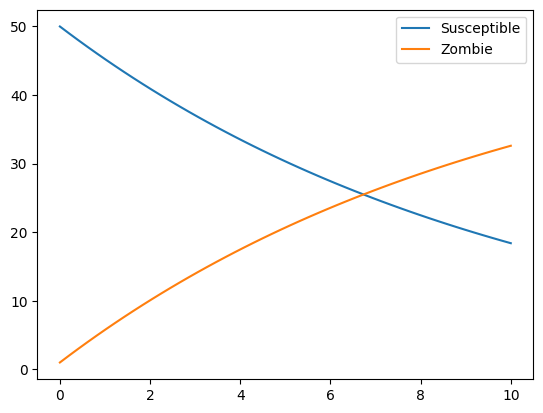

In [6]:
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
sim1 = uniform_time_course(model_instance, 0, 10, 50, selection_list=['time', 'S', 'Z'])
curves = {
    'Susceptible': {'x': 'time', 'y': 'S'},
    'Zombie': {'x': 'time', 'y': 'Z'}
}
plot2d(results=sim1, curves=curves, name='Figure3')

#### SED-2 document

This declarative document describes the simulation experiment, with values and processes all declared in a simple format which can be serialized to JSON and shared.

In [7]:
# SED document serialized
instance1 = {
    'time_start': 0,
    'time_end': 10,
    'num_points': 50,
    'selection_list': ['time', 'S', 'Z'],
    'UTC': '"UTC"',
    'model_path': '"susceptible_zombie.xml"',
    'curves': {
        'Susceptible': {'x': 'time', 'y': 'S'},
        'Zombie': {'x': 'time', 'y': 'Z'}
    },
    'figure1name': '"Figure1"',
    'sbml_model_from_path': {
        '_type': 'sed:sbml_model_from_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
        '_depends_on': [],
    },
    'plot2d': {
        '_type': 'sed:plot2d',
        'wires': {
            'results': 'results',
            'curves': 'curves',
            'name': 'figure1name',
        },
        '_depends_on': ['uniform_time_course'],
    },
    'uniform_time_course': {
        '_type': 'sed:uniform_time_course',
        'wires': {
            'model': 'model_instance',
            'time_start': 'time_start',
            'time_end': 'time_end',
            'num_points': 'num_points',
            'selection_list': 'selection_list',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path'],
    },
}

# fill(instance)  # autocomplete
# validate_schema(instance) # TODO -- demonstrate validation

# Serialize to JSON
json_str1 = serialize_instance(instance1)
print(json_str1)

{"time_start": 0, "time_end": 10, "num_points": 50, "selection_list": ["time", "S", "Z"], "UTC": "\"UTC\"", "model_path": "\"susceptible_zombie.xml\"", "curves": {"Susceptible": {"x": "time", "y": "S"}, "Zombie": {"x": "time", "y": "Z"}}, "figure1name": "\"Figure1\"", "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}, "_depends_on": []}, "plot2d": {"_type": "sed:plot2d", "wires": {"results": "results", "curves": "curves", "name": "figure1name"}, "_depends_on": ["uniform_time_course"]}, "uniform_time_course": {"_type": "sed:uniform_time_course", "wires": {"model": "model_instance", "time_start": "time_start", "time_end": "time_end", "num_points": "num_points", "selection_list": "selection_list", "results": "results"}, "_depends_on": ["sbml_model_from_path"]}}


#### Go from JSON string to Python script

In [8]:
# Generate the script
script1 = generate_script(json_str1, process_registry)
print(script1)

figure1name = "Figure1"
curves = {'Susceptible': {'x': 'time', 'y': 'S'}, 'Zombie': {'x': 'time', 'y': 'Z'}}
model_path = "susceptible_zombie.xml"
UTC = "UTC"
selection_list = ['time', 'S', 'Z']
num_points = 50
time_end = 10
time_start = 0
model_instance = sbml_model_from_path(path_to_sbml=model_path)
results = uniform_time_course(model=model_instance, time_start=time_start, time_end=time_end, num_points=num_points, selection_list=selection_list)
plot2d(results=results, curves=curves, name=figure1name)


#### Execute the script
You get the same results as above

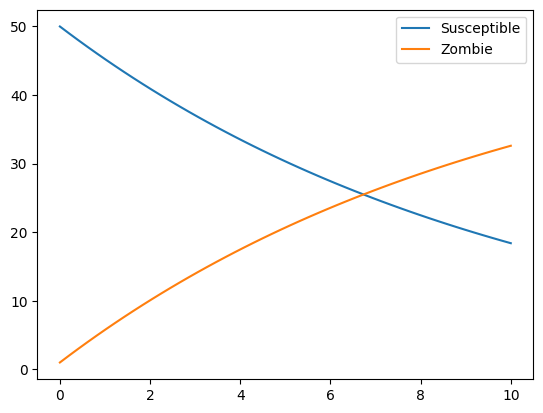

In [9]:
# Execute the script
exec(script1)

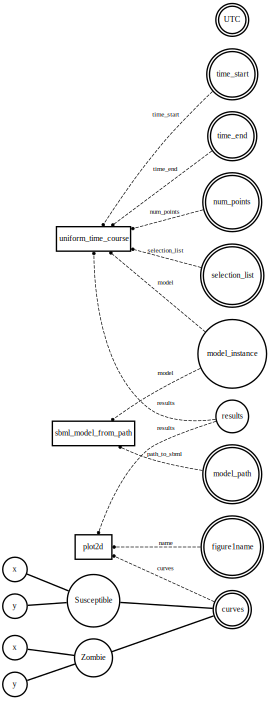

In [10]:
# Plot function map
plot_bigraph(instance1, rankdir='RL')

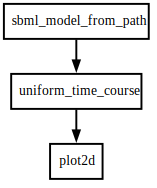

In [11]:
# Plot the flow diagram
plot_flow(instance1)

### example 2
Run a single steady-state simulation, The run returns a 1D array containing the steady state values.

The script we aim to reproduce

In [12]:
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
ss1 = steady_state(model_instance, selection_list=['S', 'Z'])
report(ss1, title='Steady States')

Steady States
S: 1.0587911840678754e-22
Z: 51.0


In [13]:
# SED document serialized
instance2 = {
    'model_path': '"susceptible_zombie.xml"',
    'sbml_model_from_path': {
        '_type': 'sed:sbml_model_from_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
        '_depends_on': []
    },
    'steady_state': {
        '_type': 'sed:steady_state',
        'wires': {
            'model': 'model_instance',
            'time_start': 'time_start',
            'time_end': 'time_end',
            'num_points': 'num_points',
            'selection_list': 'selection_list',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path']
    },
    'report': {
        '_type': 'sed:report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['steady_state']
    }
}

# Serialize to JSON
json_str2 = serialize_instance(instance2)
print(json_str2)

{"model_path": "\"susceptible_zombie.xml\"", "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}, "_depends_on": []}, "steady_state": {"_type": "sed:steady_state", "wires": {"model": "model_instance", "time_start": "time_start", "time_end": "time_end", "num_points": "num_points", "selection_list": "selection_list", "results": "results"}, "_depends_on": ["sbml_model_from_path"]}, "report": {"_type": "sed:report", "wires": {"results": "results", "title": "UTC"}, "_depends_on": ["steady_state"]}}


In [14]:
# Generate the script
script2 = generate_script(json_str2, process_registry)
print(script2)

model_path = "susceptible_zombie.xml"
model_instance = sbml_model_from_path(path_to_sbml=model_path)
results = steady_state(model=model_instance, selection_list=selection_list)
report(results=results, title=UTC)


In [15]:
# Execute the script
exec(script2)

UTC
S: 1.0587911840678754e-22
Z: 51.0


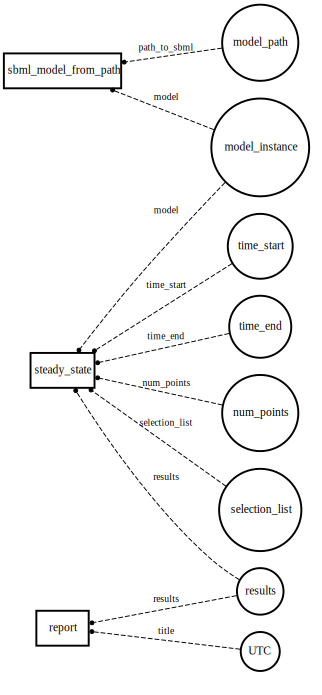

In [16]:
# Plot function map
plot_bigraph(instance2, rankdir='RL')

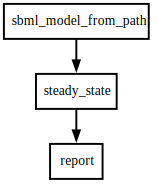

In [17]:
# Plot flow diagram
plot_flow(instance2)

### example 3
Set parameters and/or initial conditions and run time course or steady state evaluation.

In [18]:
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
set_model(model_instance, 'Z', 0.0)
ss1 = steady_state(model_instance, selection_list=['S', 'Z'])
report(ss1, title='Steady States')

Steady States
S: 1.0587911840678754e-22
Z: 51.0


In [19]:
# SED document serialized
instance3 = {
    'model_path': '"susceptible_zombie.xml"',
    'sbml_model_from_path': {
        '_type': 'sed:sbml_model_from_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
        '_depends_on': []
    },
    'element_id': '"Z"',
    'element_value': 0.0,
    'set_model': {
        '_type': 'sed:set_model',
        'wires': {
            'model_instance': 'model_instance',
            'element_id': 'element_id',
            'value': 'element_value'
        },
        '_depends_on': ['sbml_model_from_path']
    },
    'steady_state': {
        '_type': 'sed:steady_state',
        'wires': {
            'model': 'model_instance',
            'time_start': 'time_start',
            'time_end': 'time_end',
            'num_points': 'num_points',
            'selection_list': 'selection_list',
            'results': 'results',
        },
        '_depends_on': ['set_model']
    },
    'report': {
        '_type': 'sed:report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['steady_state']
    }
}

# Serialize to JSON
json_str3 = serialize_instance(instance3)
print(json_str3)

{"model_path": "\"susceptible_zombie.xml\"", "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}, "_depends_on": []}, "element_id": "\"Z\"", "element_value": 0.0, "set_model": {"_type": "sed:set_model", "wires": {"model_instance": "model_instance", "element_id": "element_id", "value": "element_value"}, "_depends_on": ["sbml_model_from_path"]}, "steady_state": {"_type": "sed:steady_state", "wires": {"model": "model_instance", "time_start": "time_start", "time_end": "time_end", "num_points": "num_points", "selection_list": "selection_list", "results": "results"}, "_depends_on": ["set_model"]}, "report": {"_type": "sed:report", "wires": {"results": "results", "title": "UTC"}, "_depends_on": ["steady_state"]}}


In [20]:
# Generate the script
script3 = generate_script(json_str3, process_registry)
print(script3)

element_value = 0.0
element_id = "Z"
model_path = "susceptible_zombie.xml"
model_instance = sbml_model_from_path(path_to_sbml=model_path)
set_model(model_instance=model_instance, element_id=element_id, value=element_value)
results = steady_state(model=model_instance, selection_list=selection_list)
report(results=results, title=UTC)


In [21]:
# Execute the script
exec(script3)

UTC
S: 1.0587911840678754e-22
Z: 51.0


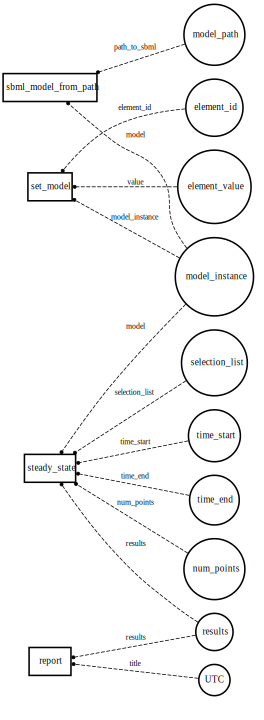

In [22]:
# Plot function map
plot_bigraph(instance3, rankdir='RL')

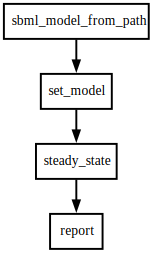

In [23]:
# Plot flow diagram
plot_flow(instance3)

### example 4
Repeat simulations any number of times and with any degree of nesting.  Any changes may be applied to parameters, initial conditions etc within the repeated simulations.  The results of the simulation will be collected into arrays.

In [24]:
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
config = {
    'Z': list(range(1, 11))
}
results = repeated_simulation(model_instance, config)
report(results, title='Different starting Z values')

Different starting Z values
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94003035 30.32651341 23.61828935 18.39390318]
Z: [ 1.         12.05996965 20.67348659 27.38171065 32.60609682]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004271 30.3265222  23.61829995 18.39387556]
Z: [ 2.         13.05995729 21.6734778  28.38170005 33.60612444]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004572 30.32652512 23.6183302  18.39399716]
Z: [ 3.         14.05995428 22.67347488 29.3816698  34.60600284]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94005934 30.32656148 23.61832184 18.39393547]
Z: [ 4.         15.05994066 23.67343852 30.38167816 35.60606453]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94006923 30.32664465 23.61839919 18.39396   ]
Z: [ 5.         16.05993077 24.67335535 31.38160081 36.60604   ]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004474 30.32656757 23.61833607 18.39394121]
Z: [ 6.         17.05995526 25.67343243 32.38166393 37.6060

In [25]:
# SED document serialized
instance4 = {
    'model_path': '"susceptible_zombie.xml"',
    'sbml_model_from_path': {
        '_type': 'sed:sbml_model_from_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
        '_depends_on': []
    },
    'repeated_sim_config':{'Z': list(range(1, 11))},
    'repeated_simulation': {
        '_type': 'sed:repeated_simulation',
        'wires': {
            'model_instance': 'model_instance',
            'config': 'repeated_sim_config',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path']
    },
    'report': {
        '_type': 'sed:report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['repeated_simulation']
    }
}

# Serialize to JSON
json_str4 = serialize_instance(instance4)
print(json_str4)

{"model_path": "\"susceptible_zombie.xml\"", "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}, "_depends_on": []}, "repeated_sim_config": {"Z": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, "repeated_simulation": {"_type": "sed:repeated_simulation", "wires": {"model_instance": "model_instance", "config": "repeated_sim_config", "results": "results"}, "_depends_on": ["sbml_model_from_path"]}, "report": {"_type": "sed:report", "wires": {"results": "results", "title": "UTC"}, "_depends_on": ["repeated_simulation"]}}


In [26]:
# Generate the script
script4 = generate_script(json_str4, process_registry)
print(script4)

repeated_sim_config = {'Z': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
model_path = "susceptible_zombie.xml"
model_instance = sbml_model_from_path(path_to_sbml=model_path)
results = repeated_simulation(model_instance=model_instance, config=repeated_sim_config)
report(results=results, title=UTC)


In [27]:
# Execute the script
exec(script4)

UTC
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94003035 30.32651341 23.61828935 18.39390318]
Z: [ 1.         12.05996965 20.67348659 27.38171065 32.60609682]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004271 30.3265222  23.61829995 18.39387556]
Z: [ 2.         13.05995729 21.6734778  28.38170005 33.60612444]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004572 30.32652512 23.6183302  18.39399716]
Z: [ 3.         14.05995428 22.67347488 29.3816698  34.60600284]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94005934 30.32656148 23.61832184 18.39393547]
Z: [ 4.         15.05994066 23.67343852 30.38167816 35.60606453]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94006923 30.32664465 23.61839919 18.39396   ]
Z: [ 5.         16.05993077 24.67335535 31.38160081 36.60604   ]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004474 30.32656757 23.61833607 18.39394121]
Z: [ 6.         17.05995526 25.67343243 32.38166393 37.60605879]
time: [ 0.   2.5  

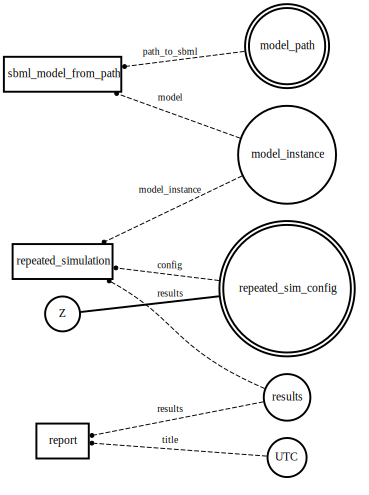

In [28]:
# Plot function map
plot_bigraph(instance4, rankdir='RL')

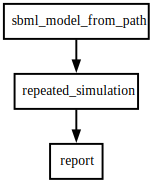

In [29]:
# Plot flow diagram
plot_flow(instance4)

### example 5
Carry out an n-D parameter scan and return the results in an array.

In [30]:
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
SZ_data = data_description('susceptible_zombie.csv', 'CSV')
config = {
    'S': np.arange(0.0, 0.010, step=0.002),
    'Z': np.arange(0.0, 0.010, step=0.002)
}
results = n_dimensional_scan(
    input_dict=config, 
    model=model_instance,
    data_description=SZ_data,
    time_start=0, 
    time_end=10, 
    num_points=5
)
report(results, title='Parameter scan')

Parameter scan
(0.0, 0.0): 0.0
(0.0, 0.002): 0.0
(0.0, 0.004): 0.0
(0.0, 0.006): 0.0
(0.0, 0.008): 0.0
(0.002, 0.0): 0.0
(0.002, 0.002): 0.0
(0.002, 0.004): 0.0
(0.002, 0.006): 0.0
(0.002, 0.008): 0.0
(0.004, 0.0): 0.0
(0.004, 0.002): 0.0
(0.004, 0.004): 0.0
(0.004, 0.006): 0.0
(0.004, 0.008): 0.0
(0.006, 0.0): 0.0
(0.006, 0.002): 0.0
(0.006, 0.004): 0.0
(0.006, 0.006): 0.0
(0.006, 0.008): 0.0
(0.008, 0.0): 0.0
(0.008, 0.002): 0.0
(0.008, 0.004): 0.0
(0.008, 0.006): 0.0
(0.008, 0.008): 0.0


In [31]:
# SED document serialized
instance5 = {
    'model_path': '"susceptible_zombie.xml"',
    'data_description_path': '"susceptible_zombie.csv"',
    'sbml_model_from_path': {
        '_type': 'sed:sbml_model_from_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
        '_depends_on': []
    },
    'data_format': '"CSV"',
    'data_description': {
        '_type': 'sed:data_description',
        'wires': {
            'data_file': 'data_description_path',
            'file_format': 'data_format',
            'data': 'SZ_data',  # the output
        },
        '_depends_on': []
    },
    'n_dimensional_scan_config': {
        'S': np.arange(0.0, 0.010, step=0.002),
        'Z': np.arange(0.0, 0.010, step=0.002)
    },
    'time_start': 0,
    'time_end': 10,
    'num_points': 5,
    'n_dimensional_scan': {
        '_type': 'sed:n_dimensional_scan',
        'wires': {'input_dict': 'dict',
            'input_dict': 'n_dimensional_scan_config',
            'model': 'model_instance',
            'data_description': 'SZ_data',
            'time_start': 'time_start',
            'time_end': 'time_end',
            'num_points': 'num_points',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path']
    },
    'report': {
        '_type': 'sed:report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['n_dimensional_scan']
    }
}

# Serialize to JSON
json_str5 = serialize_instance(instance5)
print(json_str5)

{"model_path": "\"susceptible_zombie.xml\"", "data_description_path": "\"susceptible_zombie.csv\"", "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}, "_depends_on": []}, "data_format": "\"CSV\"", "data_description": {"_type": "sed:data_description", "wires": {"data_file": "data_description_path", "file_format": "data_format", "data": "SZ_data"}, "_depends_on": []}, "n_dimensional_scan_config": {"S": [0.0, 0.002, 0.004, 0.006, 0.008], "Z": [0.0, 0.002, 0.004, 0.006, 0.008]}, "time_start": 0, "time_end": 10, "num_points": 5, "n_dimensional_scan": {"_type": "sed:n_dimensional_scan", "wires": {"input_dict": "n_dimensional_scan_config", "model": "model_instance", "data_description": "SZ_data", "time_start": "time_start", "time_end": "time_end", "num_points": "num_points", "results": "results"}, "_depends_on": ["sbml_model_from_path"]}, "report": {"_type": "sed:report", "wires": {"results": "results", "title": "U

In [32]:
# Generate the script
script5 = generate_script(json_str5, process_registry)
print(script5)

num_points = 5
time_end = 10
time_start = 0
n_dimensional_scan_config = {'S': [0.0, 0.002, 0.004, 0.006, 0.008], 'Z': [0.0, 0.002, 0.004, 0.006, 0.008]}
data_format = "CSV"
data_description_path = "susceptible_zombie.csv"
model_path = "susceptible_zombie.xml"
model_instance = sbml_model_from_path(path_to_sbml=model_path)
SZ_data = data_description(data_file=data_description_path, file_format=data_format)
results = n_dimensional_scan(input_dict=n_dimensional_scan_config, model=model_instance, data_description=SZ_data, time_start=time_start, time_end=time_end, num_points=num_points)
report(results=results, title=UTC)


In [33]:
# Execute the script
exec(script5)

UTC
(0.0, 0.0): 0.0
(0.0, 0.002): 0.0
(0.0, 0.004): 0.0
(0.0, 0.006): 0.0
(0.0, 0.008): 0.0
(0.002, 0.0): 0.0
(0.002, 0.002): 0.0
(0.002, 0.004): 0.0
(0.002, 0.006): 0.0
(0.002, 0.008): 0.0
(0.004, 0.0): 0.0
(0.004, 0.002): 0.0
(0.004, 0.004): 0.0
(0.004, 0.006): 0.0
(0.004, 0.008): 0.0
(0.006, 0.0): 0.0
(0.006, 0.002): 0.0
(0.006, 0.004): 0.0
(0.006, 0.006): 0.0
(0.006, 0.008): 0.0
(0.008, 0.0): 0.0
(0.008, 0.002): 0.0
(0.008, 0.004): 0.0
(0.008, 0.006): 0.0
(0.008, 0.008): 0.0


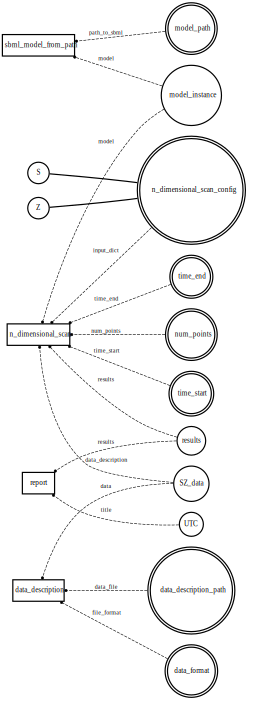

In [34]:
# Plot function map
plot_bigraph(instance5, rankdir='RL')

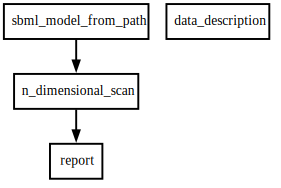

In [35]:
# Plot flow diagram
plot_flow(instance5)

## scripts to declarative and back

### toy processes

In [36]:
@ports({
    'inputs': {'a': 'int', 'b': 'int'}, 
    'outputs': {'c': 'int'}})
@annotate('math:add')
def add(a, b):
    return a + b

@ports({
    'inputs': {'a': 'int', 'b': 'int'}, 
    'outputs': {'c': 'int'}})
@annotate('math:multiply')
def multiply(a, b):
    return a * b

@ports({'inputs': {'a': 'Any'}})
@annotate('math:print_result')
def print_result(a):
    print(a)

### register toy processes

In [37]:
# register processes
functions = [
    add, 
    multiply, 
    print_result,
]
toy_process_registry = register(functions)
print(pf(toy_process_registry.registry))

{ 'add': { 'annotation': 'math:add',
           'ports': { 'inputs': {'a': 'int', 'b': 'int'},
                      'outputs': {'c': 'int'}},
           'process': <function add at 0x29a363d30>},
  'multiply': { 'annotation': 'math:multiply',
                'ports': { 'inputs': {'a': 'int', 'b': 'int'},
                           'outputs': {'c': 'int'}},
                'process': <function multiply at 0x29a363ca0>},
  'print_result': { 'annotation': 'math:print_result',
                    'ports': {'inputs': {'a': 'Any'}},
                    'process': <function print_result at 0x29a363c10>}}


In [38]:
# desired script
d = 5
b = 3
a = 2
sum_result = add(a=a, b=b)
product_result = multiply(a=sum_result, b=d)
print_result(a=product_result)

25


### declarative json string

In [39]:
# Example function calls with input and output arguments
toy_instance = {
    'print_result': {
        '_type': 'math:print_result',
        'wires': {
            'a': 'product_result', 
        },
        '_depends_on': ['multiply'],
    },
    'add': {
        '_type': 'math:add',
        'wires': {
            'a': 'a', 
            'b': 'b', 
            'c': 'sum_result',
        }
    },
    'multiply': {
        '_type': 'math:multiply',
        'wires': {
            'a': 'sum_result', 
            'b': 'd',
            'c': 'product_result',
        },
        '_depends_on': ['add'],
    },
    'a': 2,
    'b': 3,
    'd': 5,
}

# fill(instance)  # autocomplete
# validate_schema(instance) # TODO -- demonstrate validation

# Serialize to JSON
json_str = serialize_instance(toy_instance)
print(json_str)

{"print_result": {"_type": "math:print_result", "wires": {"a": "product_result"}, "_depends_on": ["multiply"]}, "add": {"_type": "math:add", "wires": {"a": "a", "b": "b", "c": "sum_result"}}, "multiply": {"_type": "math:multiply", "wires": {"a": "sum_result", "b": "d", "c": "product_result"}, "_depends_on": ["add"]}, "a": 2, "b": 3, "d": 5}


### generate a script from the json string

In [40]:
# Generate the script
script = generate_script(json_str, toy_process_registry)
print(script)

d = 5
b = 3
a = 2
sum_result = add(a=a, b=b)
product_result = multiply(a=sum_result, b=d)
print_result(a=product_result)


In [41]:
# execute the script
exec(script)

25


### plot function map

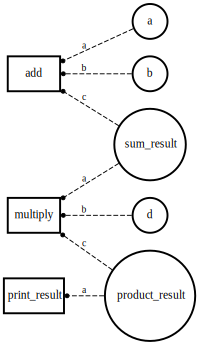

In [42]:
plot_bigraph(toy_instance, rankdir='RL')

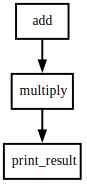

In [43]:
plot_flow(toy_instance)

### make a composite process that only exposes the outer ports

In [44]:
# add ports to the previous toy instance
instancex = {
    **toy_instance,
    '_ports': {
        'inputs': {
            'a': 'float',
            'b': 'float',
            'd': 'float',
        },
        'outputs': {
            'product_result': 'float'
        }
    },
    '_annotation': {}
}

# fill(instance)  # autocomplete
# validate_schema(instance) # TODO -- demonstrate validation

# Serialize to JSON
json_strx = serialize_instance(instancex)
print(json_strx)

{"print_result": {"_type": "math:print_result", "wires": {"a": "product_result"}, "_depends_on": ["multiply"]}, "add": {"_type": "math:add", "wires": {"a": "a", "b": "b", "c": "sum_result"}}, "multiply": {"_type": "math:multiply", "wires": {"a": "sum_result", "b": "d", "c": "product_result"}, "_depends_on": ["add"]}, "a": 2, "b": 3, "d": 5, "_ports": {"inputs": {"a": "float", "b": "float", "d": "float"}, "outputs": {"product_result": "float"}}, "_annotation": {}}


In [45]:
def generate_composite_process(json_str, process_registry):
    deserialized_wiring = deserialize_instance(json_str)
    ports = deserialized_wiring.pop('_ports')
    input_ports = ports.get('inputs')
    output_ports = ports.get('outputs')
    input_port_values = {}
    for port_name in input_ports.keys():
        input_port_values[port_name] = deserialized_wiring.pop(port_name, None)
    script = generate_script(deserialized_wiring, process_registry)
    
    # make the composite process as a string
    func_str = ''
    return_str = ''
    if ports:
        func_str += f'@ports({ports})\n'
    if input_ports:
        input_args_str = ', '.join([f'{port_name}: {value} = {input_port_values[port_name]}' for port_name, value in input_ports.items()])
        func_str += f'def composite_process({input_args_str})'
    else:
        func_str += f'def composite_process()'
    if output_ports:
        output_args_str = ', '.join([f'{value}' for key, value in output_ports.items()])
        func_str += f' -> {output_args_str}:\n'
        return_str = ', '.join([f'{key}' for key, value in output_ports.items()])
        return_str = '\nreturn ' + return_str
    else:
        func_str += f':\n'
    
    indent = '    '
    indented_script = textwrap.indent(script, indent)
    indented_return_str = textwrap.indent(return_str, indent)
    func_str += indented_script
    func_str += indented_return_str
    
    print(func_str)
    exec(func_str, globals())
    return globals()['composite_process']


def get_process_schema(process):
    ports = process.ports
    input_ports = ports.get('inputs', {})
    output_ports = ports.get('outputs', {})
    name = process.__name__
    schema = {name: {
        '_ports': {**input_ports, **output_ports}}}
    return schema

In [46]:
# Generate the composite function
composite_process = generate_composite_process(json_strx, toy_process_registry)

@ports({'inputs': {'a': 'float', 'b': 'float', 'd': 'float'}, 'outputs': {'product_result': 'float'}})
def composite_process(a: float = 2, b: float = 3, d: float = 5) -> float:
    _annotation = {}
    sum_result = add(a=a, b=b)
    product_result = multiply(a=sum_result, b=d)
    print_result(a=product_result)
    return product_result


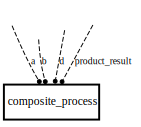

In [47]:
plot_bigraph(get_process_schema(composite_process))

In [48]:
result = composite_process(a=4)

35


In [49]:
result = composite_process(b=5.5)

37.5
